In [1]:
import sys, os, glob
import numpy as np
import scipy as sc
from glob import glob


from scipy.spatial.distance import euclidean as distance
# These are both suppose to compute a distance matrix, but cdist does not seem to return the right size
from scipy.spatial.distance import cdist as sc_distmatrix
from scipy.spatial import distance_matrix


from scipy.stats import maxwell
import matplotlib.pyplot as plt
from itertools import product

In [2]:
coulconst = sc.constants.physical_constants['conventional value of coulomb-90'][0]

# Classes 

## Simulation

In [3]:
class Simulation:
    
    
    req_param = ['nsteps', 'dt']
    


    def __init__(self, coords, ff, param, randvel=False):
        
        self.init_coords, self.atypes = self._parse_coords(coords)
        self.ff = self._parse_ff(ff)
        self.param = self._parse_param(param) 
        
        
        
        self.atomlist = [Atom(i, atype, self.init_coords[i], *self.ff[atype]) 
                         for i, atype in enumerate(self.atypes) ]
    
        self.natoms = len(self.atomlist)
    
    
        self.randvel = randvel
    
        self.dt = self.param['dt']
    
    
    
    
    
        ##################################
        # Create arrays of atom properties
        
        self.masses = np.array([atom.mass for atom in self.atomlist]).reshape(self.natoms, 1)
        self.sigmas = np.array([[atom.sigma] for atom in self.atomlist]).reshape(self.natoms, 1)
        self.epsilons = np.array([[atom.epsilon] for atom in self.atomlist]).reshape(self.natoms, 1)
        self.charges = np.array([[atom.charge] for atom in self.atomlist]).reshape(self.natoms, 1)
        self.charge_matrix = self.charges * self.charges.T
    
    
    
    
    #######################
    ### variable parsing:
    def _parse_coords(self, coords ):
        # Should input a dct or file, and format it into a dictionary for .run()
        # The dict sjould have keys for the atom names and their coords
        return coords['coords'], coords['names']
        
    def _parse_param(self, param):
        
        for parm in self.req_param:
            if parm not in param:
                raise Exception('{parm} was not in the param dict')
        
        return param
          
    def _parse_ff(self, ff):
        # Input can be dict or file, this should format it into a dictionary (or ff obj?)
        # Dict should be keys of atom types, with a list of the [mass, charge, sigma, epsilon]
        
        for atype in self.atypes:
            if atype not in ff.keys():
                raise Exception('Atom type: {atype} was not found in the ff')
                
        return ff
        
        
    #######################################################################           
    
    def run(self, skip=1):
        
        # prev: t
        # New : t + dt

        
        self.traj = []
        self.ftraj = []
        
        
        ###################################
        # Initialize positions, velocities, and forces
        prev_vels = self.gen_velocities()
        prev_xyz = self.init_coords
        
        prev_forces = self.update_forces(prev_xyz)

        
        
        ###################
        # Main traj loop.
        for step in np.arange(0, self.param['nsteps'], 1):
            
            new_xyz = self.update_xyz(prev_xyz, prev_forces, prev_vels)
            
            new_forces = self.update_forces(new_xyz)
            
            new_vels = self.update_vels(prev_forces, new_forces, prev_vels)
        

            # Save values for trajectory   
            if step % skip == 0:
                self.traj.append(new_xyz)
                self.ftraj.append(new_forces)
    
    
            # Reset for next loop
            prev_xyz = new_xyz
            prev_forces = new_forces
            prev_vels = new_vels
            
        print(f'Completed {step} steps')
    
    
    def update_xyz(self, prev_xyz, prev_forces, prev_vels):
        self.next_xyz = prev_xyz + self.dt * prev_vels + ((self.dt ** 2) / 2 * self.masses) * prev_forces
        return self.next_xyz
    
    def update_vels(self, prev_forces, new_forces, prev_vels):
        self.new_vels = prev_vels + (self.dt / 2 * self.masses) * (prev_forces + new_forces)
        return self.new_vels
    
    
    def update_forces(self, xyz):
        
            ###################################
            # Calculate distances
            # Using scipy func
            # Scipy also has neighbour searching algs
       
            # natoms * natoms matrix
            self.distances = sc_distmatrix(xyz, xyz)
            
            # The diagonal is masked with nan as atom i=j, dist=0. This supresses div/0 warnings)
            self.distances[np.diag_indices(self.natoms)] = np.nan 
            
            
            
            ##############################
            # Calculate interactions
            
            # lennard jones energy
#             The 12 6 eq calcs the ptential E. Derivative must be taken to get the F
            self.lj_f = self.calc_lj(self.epsilons, self.sigmas, self.distances)
            
            
            
            # Electrostatics
            self.coul_f = coulconst * ( (self.charge_matrix) / (self.distances ** 2))
            
            # Sum forces on atom pairs
            # natoms * natoms
            self.pairwise_forces = self.coul_f + self.lj_f
            
            
            
            ################################
            # Force decomposition
            # Find the unit vector of the distance vector, then multiple by force
            # The distance vector is difference in the coord vectors of atoms i, j
            
            # Duplicate the coord vectors, so a natoms * natoms * 3 matrix can be formed
            #          
            # i1 ---   |||
            # i2 --- * |||
            # i3 ---   |||
            
            # This is so each coord vector is able to be subtracted against every other

            self.xyz1 = np.tile(xyz, self.natoms).reshape(self.natoms, self.natoms, 3)
            self.xyz2 = np.rot90(self.xyz1, axes=(0,1))
            
            # Should be a natoms * natoms * 3 matrix. 
            # Reshaping is to append 1d
            self.f_decomposed = (self.xyz1 - self.xyz2 ) / self.distances.reshape(self.natoms, self.natoms, 1) * self.pairwise_forces.reshape(self.natoms, self.natoms, 1)
            
            # Sum across atoms to get total F on each atom. natoms * 3 matrix
            self.new_forces = np.sum(np.nan_to_num(self.f_decomposed), axis=1)
                
            return self.new_forces
        
        

    
    # inputs must be array of size (natoms, 1) and (natoms, natoms)
    def calc_lj(self, e, sig, dists):
        
        difference = 0.0001
        close_dists = dists + difference
        
        
               
        V1 = 4 * e * (  (sig / dists ) ** 12   -   ( sig / dists  ) ** 6  )
        V2 = 4 * e * (  (sig / close_dists ) ** 12   -   ( sig / close_dists  ) ** 6  )
        
        Vdiff = V2 - V1
        
        return Vdiff / difference
        
        
    
    # What about the temperature???
    # Only positive nums returned
    def gen_velocities(self,):
        
        if self.randvel == True:
        
        
            velsx = maxwell.rvs(size=len(self.atomlist))
            velsy = maxwell.rvs(size=len(self.atomlist))
            velsz = maxwell.rvs(size=len(self.atomlist))
            
            vels = np.array(list(zip(velsx, velsy, velsz)))
            
            return  vels
        
        else:
            return np.array([[0,0,0] * self.natoms]).reshape(self.natoms, 3)
        

    
    # outputs xyz format
    def output_traj(self, fname ):
        f = open(fname, 'w')

        for frame in self.traj:
            f.write(str(self.natoms)+ '\n')
            f.write('\n')
            for i, atom, in enumerate(self.atomlist): 
                f.write(f'{atom.atype} {frame[i][0]} {frame[i][1]} {frame[i][2]} \n')
            
                
        f.close()
        
        
        
    
    
class Atom:
    def __init__(self, index, atype, xyz, mass, charge, sigma, epsilon):
        
        self.index = index
        self.atype = atype
        
        self.xyz = xyz
        self.mass = mass
        self.charge = charge
        self.sigma = sigma
        self.epsilon = epsilon
        
        self.prevxyz = self.xyz
        self.vel = None
        self.prevel = None

## Auxillary functions

In [4]:
def gen_rand_coords(n_atoms, scaling, atypes):
    
       
    structure_dict = {
        'names': atypes * n_atoms,
        'coords':  np.random.random((len(atypes) * n_atoms, 3)) * scaling ,
    }
        
    return structure_dict
    

In [5]:

# Gen cube system

def gen_cube(spacing, natoms_in_dim, motif):

    args = [0, natoms_in_dim * spacing, spacing]
    tups =  list(product(np.arange(*args), np.arange(*args), np.arange(*args)))
    coords = [list(tup) for tup in tups]
    
    Cube = {
        'names' : motif * int(natoms_in_dim / len(motif))   * natoms_in_dim * natoms_in_dim,
        'coords': coords,
        
    }
    return Cube

## Play space

### Parameters and things

In [15]:
# Systems

# Salt cube
cube = gen_cube(2.5, 4, ['Na', 'Cl'])


# Salt line
line = {
    'names': ['Na', 'Cl', 'Na', 'Cl'],
    'coords':np.array([[0,0,0],[1,0,0], [2,0,0], [3,0,0]])
}


# Na - Cl two atoms
nacl = {
    'names': ['Na', 'Cl',],
    'coords': np.array([[0,0,0],[5,0,0],])
}

In [22]:
# Atomname: [mass, charge, sigma, epsilon]
# Format not great if connectivity was introduced

realff = {
    
    
        'LJ':[23.0, 0, 0.22, 0.13],
        'Na':[23.0, 1, 0.22, 0.13],
        'Cl':[35.45, -1, 0.22, 0.13],
}

funff = {
    
    'LJ':[23, 0, 0.5, 1000],
    'Na':[23, 1, 0.5, 10],
    'Cl':[35.45, -1, 0.5, 10],
    
    
}
 
param = {
    
    'dt': 0.01,
    'nsteps': 10000,
    
    
    
}



### Run

In [23]:
system = cube
s = Simulation(system, realff, param, randvel = False)

In [24]:
s.run(skip=10)

Completed 9999 steps


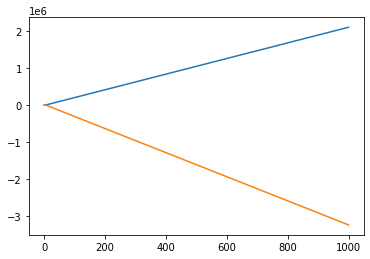

In [25]:
nacl_traj = [ (s.traj[x][:, 0][0], s.traj[x][:, 0][1])  for x in np.arange(0, len(s.traj), 1)]

natraj, cltraj = list(zip(*nacl_traj))

t = np.arange(0, len(s.traj), 1)
plt.plot(t, natraj, t, cltraj)

In [26]:
len(s.traj)

1000

In [27]:
s.output_traj('saltcube.xyz')

## 1D Na - Cl system

In [200]:
# 1D, hard coded Na - Cl system

def coulf(const, qq, dist):
    return const * ( (qq) / ( dist ** 2))
    
def ljf(e, sig, dist):
    
    # To compute force, differentiate by finding gradient between two very close poitns
    diff = 0.0001
    dist2 = dist +  diff
    
    V1 = 4 * e * ( ( sig / dist) ** 12 - ( sig / dist ) ** 6 )
    V2 = 4 * e * ( ( sig / dist2) ** 12 - ( sig / dist2 ) ** 6 )
    
    Vdiff = V2 - V1
    
    return Vdiff / diff
    

def fdecomp(ai, aj, dist, fsum):
    return (ai - aj ) / dist * fsum

def newX(x0, v0, dt, m, fdecomp):
    return x0 + dt * v0 + (dt ** 2) / 2 * m * fdecomp

def newV(v0, dt, m, fold, fnew):
    return v0 + dt / 2 * m * (fold + fnew)


  
    
dt =  0.05

namass = 23
naxyz = 0
navel = 0
ncurrf = 0
na_e = 10
na_sig = 2.5
natraj = []
naf = []

clmass = 35.45
clxyz = 15
clvel = 0
ccurrf = 0
cl_e = 10
cl_sig = 2.5
cltraj = []


cforces = []
ljforces = []
dists = []
vels = []
clf = []

dists = []


for i in range(0, 1000):
    
    dist = np.abs(naxyz - clxyz)
  
    
    # Calc forces
    # Na:
    ncoulf = coulf(coulconst, -1, dist)
    nljf = ljf(na_e, na_sig, dist)
    nsumf = nljf + ncoulf
    nnewf = fdecomp(naxyz, clxyz, dist, nsumf)
    
    # Cl:
    ccoulf = coulf(coulconst, -1, dist)
    cljf = ljf(cl_e, cl_sig, dist)
    csumf = cljf + ccoulf
    cnewf = fdecomp(clxyz, naxyz, dist, csumf)
    
    
    
    
    # Update pos
    # Na:
    naxyz = newX(naxyz, navel, dt, namass, nnewf)
    navel = newV(navel, dt, namass, nnewf, ncurrf)
    ncurrf = nnewf
    
    # Cl:
    clxyz = newX(clxyz, clvel, dt, clmass, cnewf)
    clvel = newV(clvel, dt, clmass, cnewf, ccurrf)
    ccurrf = cnewf
    
    
    # save results
    natraj.append(naxyz)
    cltraj.append(clxyz)
    naf.append(nnewf)
    clf.append(cnewf)
    dists.append(dist)
    
  
    
    
    if  ncurrf > 1:
        print(f'crashed at step {i}')
        break

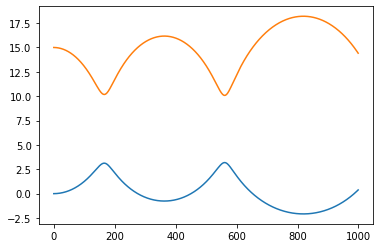

In [201]:
# Pos vs time
t = np.arange(0, len(dists))
plt.plot(t, natraj, t, cltraj )

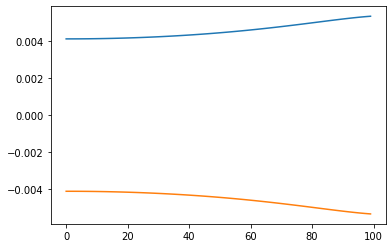

In [129]:
# Force v time
t = np.arange(0, len(dists))
plt.plot(t, naf, t, clf )

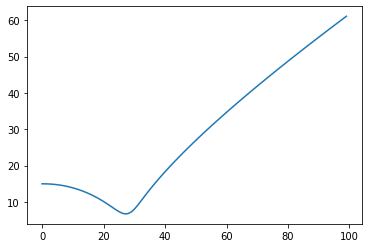

In [124]:
# dist vs time
plt.plot(dists)

In [140]:
np.sum(np.array(naf) + np.array(clf))

0.0

In [138]:
naf[0] + clf[0]

0.0

In [137]:
print(naf[0], clf[0])

0.004101516010558028 -0.004101516010558028
